In [1]:
from ham import *
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# ==== Model Parameters ====
n_batch = 100
n_image = 28*28
n_classes = 10
device = torch.device('cpu')
dtype = torch.float32

In [3]:
# ==== Create Model ====
neurons = {
    'input': TanhNeuron(shape=(n_image,)),
    'hidden': TanhNeuron(shape=(n_image,)),
    'label': SoftmaxNeuron(shape=(n_classes,)),
}

synapses = {
    's0': DenseSynapse(n_image, n_image, device=device, dtype=dtype),
    's1': DenseSynapse(n_image, n_classes, device=device, dtype=dtype)
}

connections = {
    's0': ['input', 'hidden'],
    's1': ['hidden', 'label']
}

model = HAM(neurons, synapses, connections)

In [4]:
# ==== Load Data ====
transform =transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0), (1.0))])
train_set = datasets.MNIST(os.path.expanduser('~/data'), train=True, download=True, transform=transform)
test_set = datasets.MNIST(os.path.expanduser('~/data'), train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=n_batch)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=n_batch)

In [5]:
# ==== Setup Optimizer ====
optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [6]:
# ==== Training Loop ====
n_epochs = 2
depth = 5
dt = 0.1

for e in range(n_epochs):
    for i, (x, y) in enumerate(train_loader):
        
        # Init states
        states = model.init_states(n_batch=n_batch, device=device, dtype=dtype, requires_grad=True)
        states['input'] = x.view(n_batch, -1).to(device=device, dtype=dtype).requires_grad_(True)

        # Move labels to device
        y = y.to(device=device, dtype=torch.long)

        optim.zero_grad()

        for d in range(depth):
            activations = model.neuron_activations(states)
            updates, energy = model.updates(states, activations, pin={'input'}, return_energy=True)
            states = model.step(states, updates, dt)
        
        logits = states['label']
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)
        print(f'epoch = {e+1:03d}/{n_epochs:03d}, batch = {i+1:05d}/{len(train_loader):05d}, loss = {loss.item():2.8f}', end='\r',  flush=True)
        loss.backward()
        optim.step()

torch.Size([1, 28, 28])


<IPython.core.display.Javascript object>


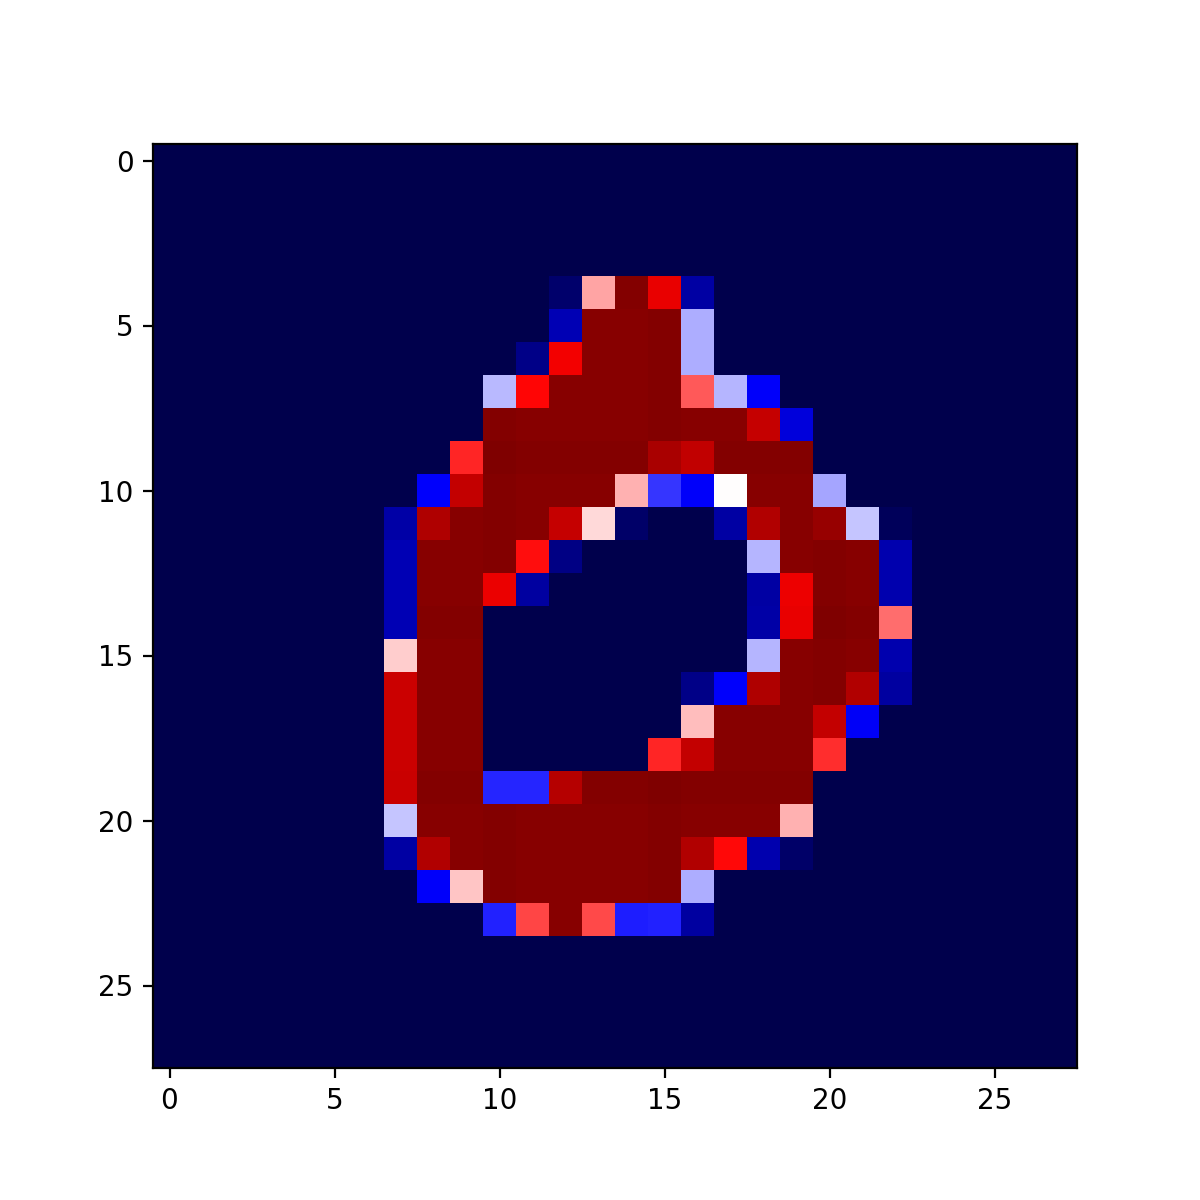

In [15]:
%matplotlib notebook

# Get an unseen test pair
x, y = test_set[3]

print(x.shape)

plt.figure(figsize=(6, 6))
plt.imshow(x.squeeze(), cmap='seismic')
plt.show()

In [16]:
states = model.init_states(n_batch=1, device=device, dtype=dtype, requires_grad=True)
states['input'] = x.view(1, -1).to(device=device, dtype=dtype).requires_grad_(True)

for t in range(100):
    activations = model.neuron_activations(states)
    updates, energy = model.updates(states, activations, pin={'input'}, return_energy=True)
    states = model.step(states, updates, dt=0.01)
    print(energy.item())

64.13528442382812
-73.61418151855469
-172.1806182861328
-239.1680908203125
-284.568603515625
-315.80706787109375
-337.73828125
-353.45562744140625
-364.9332275390625
-373.4483642578125
-379.841796875
-384.68450927734375
-388.3761291503906
-391.2033386230469
-393.3779296875
-395.0573425292969
-396.359619140625
-397.3728332519531
-398.16424560546875
-398.7850341796875
-399.2728271484375
-399.65740966796875
-399.9614562988281
-400.2030029296875
-400.39447021484375
-400.5473327636719
-400.66888427734375
-400.76654052734375
-400.84356689453125
-400.9062805175781
-400.9561462402344
-400.9966125488281
-401.0289611816406
-401.05450439453125
-401.0755920410156
-401.0927429199219
-401.1064147949219
-401.116943359375
-401.1261291503906
-401.1327209472656
-401.1383972167969
-401.1431884765625
-401.1470947265625
-401.1499938964844
-401.15234375
-401.15460205078125
-401.1563415527344
-401.15728759765625
-401.1585388183594
-401.1591491699219
-401.159912109375
-401.1605224609375
-401.1611633300781
-40

In [17]:
activations = model.neuron_activations(states)
print(torch.argmax(activations['label'].flatten()))

tensor(0)


In [23]:
states = model.init_states(n_batch=1, device=device, dtype=dtype, requires_grad=True)
states['label'] = F.one_hot(torch.tensor(3), num_classes=n_classes).to(device=device, dtype=dtype).view(1, -1).requires_grad_(True)

for t in range(100):
    activations = model.neuron_activations(states)
    updates, energy = model.updates(states, activations, pin={'label'}, return_energy=True)
    states = model.step(states, updates, dt=0.001)
    print(energy.item())

-1.9634891748428345
-1.9946783781051636
-2.024257183074951
-2.0525193214416504
-2.079754590988159
-2.1062798500061035
-2.132343053817749
-2.1583456993103027
-2.184418201446533
-2.210754632949829
-2.237895965576172
-2.2659451961517334
-2.2953572273254395
-2.3264944553375244
-2.3599047660827637
-2.3962197303771973
-2.435988426208496
-2.480027437210083
-2.5284368991851807
-2.582491159439087
-2.642707586288452
-2.7103590965270996
-2.786121129989624
-2.8712875843048096
-2.9677586555480957
-3.077226400375366
-3.201676845550537
-3.343222141265869
-3.506032943725586
-3.6925370693206787
-3.9069983959198
-4.15400505065918
-4.438766002655029
-4.766618728637695
-5.143259048461914
-5.575496673583984
-6.070951461791992
-6.640402793884277
-7.295085906982422
-8.046838760375977
-8.90984058380127
-9.901063919067383
-11.03884220123291
-12.345993041992188
-13.847541809082031
-15.572404861450195
-17.554563522338867
-19.83140754699707
-22.446578979492188
-25.45020294189453
-28.90034294128418
-32.86205673217

<IPython.core.display.Javascript object>


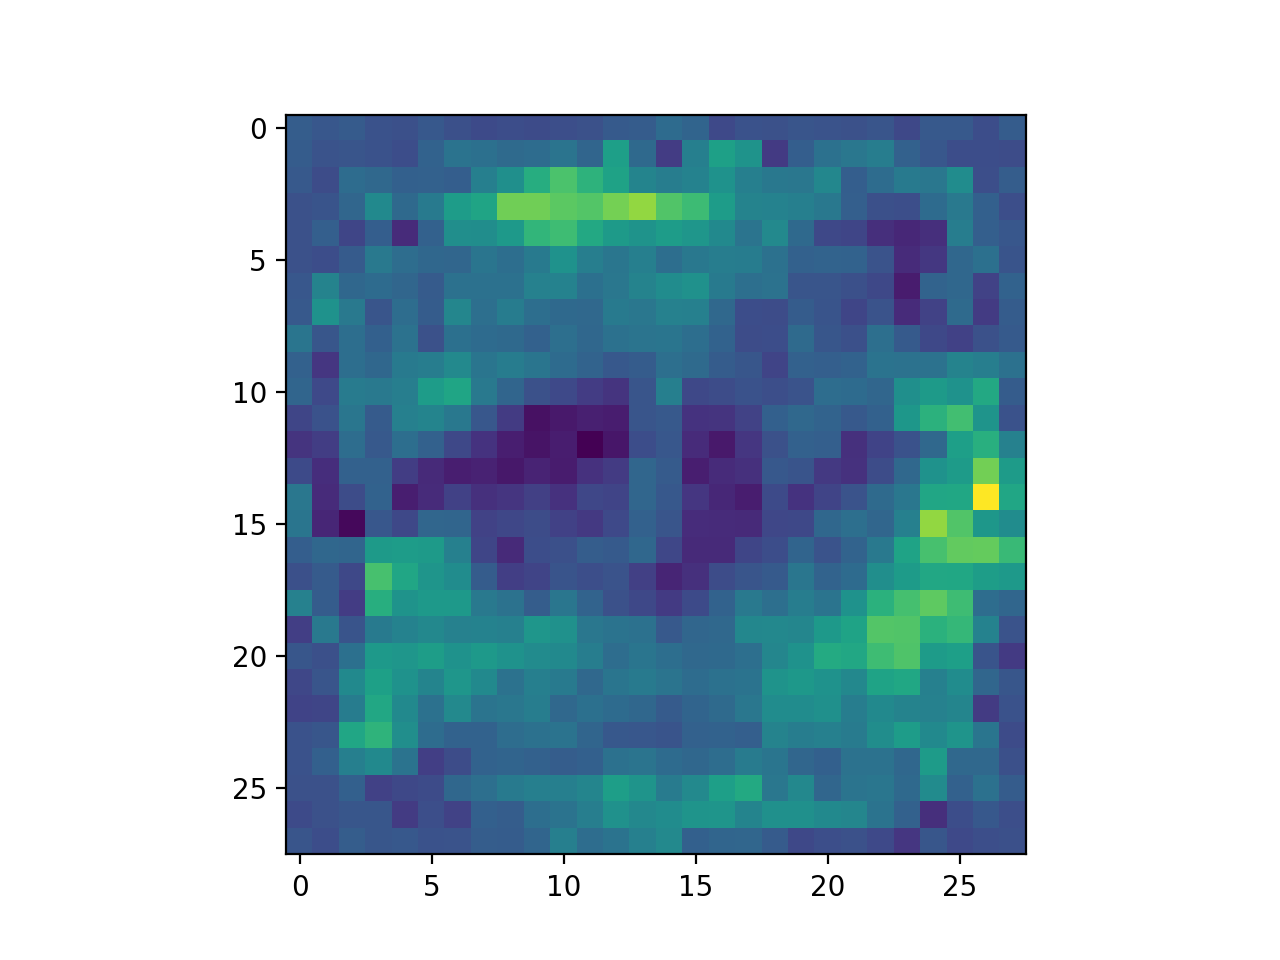

In [27]:
plt.figure()
plt.imshow(states['input'].detach().squeeze().reshape(28, 28))